In [27]:
import sys

%matplotlib inline
%reload_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import math
from astropy.table import Table, Column
from scipy import interpolate
from scipy import integrate
from matplotlib import rc
from scipy.integrate import quad
from scipy.integrate import simps
from math import pi
import pandas
import numpy.random
import random
import numpy as np
import Corrfunc
from matplotlib import pyplot
from Corrfunc.theory import wp

rc('text', usetex=True)



In [5]:
Omega_m0 = 0.3
Omega_L0 = 0.7
Gamma = 0.2
a = 0.707

# Functions

#    Eisenstein 1999

def func_g_squared(z, Omega_m0=0.3, Omega_L0=0.7):
    matter = Omega_m0*(1+z)**3
    curvature = (1 - Omega_m0 - Omega_L0)*(1+z)**2
    return matter + curvature + Omega_L0

#    The linear growth function. eq 10 Eisenstein 1999
#    N.B. Omega = Omega(z), Omega_L = Omega_L(z)

def func_D(Omega, Omega_L):
    # Helper functions
    A = 5 * Omega / 2
    B = Omega**(4/7.) - Omega_L
    C = 1 + Omega / 2
    D = 1 + Omega_L / 70.
    
    D = A / (B + C * D)
    
    return D

#    Eisenstein 1999

def func_Omega_L(Omega_L0, g_squared):
    return Omega_L0 / g_squared

#    delta_c as a function of omega and linear growth
#    van den Bosch 2001

def func_delta_c(delta_0_crit, D):
    return delta_0_crit / D

#    A3 van den Bosch 2001

def func_delta_0_crit(Omega, p):
    return 0.15 * (12*pi)**(2/3.) * Omega**p

#    A4 van den Bosch 2001

def func_p(Omega_m0, Omega_L0):
    
    if (Omega_m0 < 1 and Omega_L0 == 0):
        return 0.0185
    if (Omega_m0 + Omega_L0 == 1.0):
        return 0.0055

#    A5 van den Bosch 2001 / eq 10 Eisenstein 1999

def func_Omega(z, Omega_m0, g_squared):
    return Omega_m0 * (1+z)**3 / g_squared

#    A8 van den Bosch 2001

def func_sigma(sigma_8, f, f_8):
    return sigma_8 * f / f_8

#    A9 van den Bosch 2001

def func_u_8(Gamma):
    return 32 * Gamma

#    A9 van den Bosch 2001
def func_u(Gamma, M, Omega_0=.3):
    return 3.804e-4 * Gamma * (M/Omega_0)**(1/3.)

#    A10 van den Bosch 2001
def func_f(u):
    common = 64.087
    factors = (1, 1.074, -1.581, 0.954, -0.185)
    exps = (0, 0.3, 0.4, 0.5, 0.6)
    
    ret_val = 0.0
    for i in range(len(factors)):
        ret_val += factors[i] * u ** exps[i]
    
    return common * ret_val**(-10)


#    eq. 8 Sheth 2001
def func_b_eul(nu, delta_sc=1.686, a=0.707, b=0.5, c=0.6):
    # A bunch of helper functions
    A = np.sqrt(a) * delta_sc
    B = np.sqrt(a) * a * nu**2
    C = np.sqrt(a) * b * (a * nu**2)**(1-c)
    D = (a * nu**2)**c
    E = (a*nu**2)**c + b*(1-c)*(1-c/2)
    
    return 1 + (B + C - D/E)/A

#    eq. 8 Tinker 2005

def func_b_eulTin(nu, delta_sc=1.686, a=0.707, b=0.35, c=0.8):
    # A bunch of helper functions
    A = np.sqrt(a) * delta_sc
    B = np.sqrt(a) * a * nu**2
    C = np.sqrt(a) * b * (a * nu**2)**(1-c)
    D = (a * nu**2)**c
    E = (a*nu**2)**c + b*(1-c)*(1-c/2)
    
    return 1 + (B + C - D/E)/A

#    Estimate sigma for a set of masses

def estimate_sigma(M, z, g_squared, Omega_m0=0.3, Gamma=0.2, sigma_8=0.8):
    
    # vdb A9
    u = func_u(Gamma, M, Omega_m0)
    u_8 = func_u_8(Gamma)
    
    # vdb A10
    f = func_f(u)
    f_8 = func_f(u_8)
    
    # vdb A8
    sigma = func_sigma(sigma_8, f, f_8)
    
    return sigma

#    Estimate delta_c for a set of masses

def estimate_delta_c(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7):
    
    # Redshift/model dependant parameters
    Omega = func_Omega(z, Omega_m0, g_squared)
    Omega_L = func_Omega_L(Omega_L0, g_squared)
    
    # vdb A3
    p = func_p(Omega_m0, Omega_L0)
    
    # Allevato code
    D1 = func_D(Omega, Omega_L) / (1 + z)
    D0 = func_D(Omega_m0, Omega_L0)
    D = D1/D0
    
    delta_0_crit = func_delta_0_crit(Omega, p)
    # TODO: remove
    delta_0_crit = 1.686
    delta_c = func_delta_c(delta_0_crit, D)
    
    return (delta_c, delta_0_crit)

#Estimate the bias Sheth + 2001

def estimate_bias(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7, sigma_8=0.8):
    sigma = estimate_sigma(M, z, g_squared, Omega_m0, Gamma, sigma_8)
    delta_c, delta_0_crit = estimate_delta_c(M, z, g_squared, Gamma, Omega_m0, Omega_L0)
    
    nu = delta_c / sigma
    
    return func_b_eul(nu, delta_0_crit)

#Estimate the bias Tinker + 2005

def estimate_biasTin(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7, sigma_8=0.8):
    sigma = estimate_sigma(M, z, g_squared, Omega_m0, Gamma, sigma_8)
    delta_c, delta_0_crit = estimate_delta_c(M, z, g_squared, Gamma, Omega_m0, Omega_L0)
    
    nu = delta_c / sigma
    
    return func_b_eulTin(nu, delta_0_crit)


In [8]:
# Read cvs file from MultiDark simulations at z=0.25

data = np.load("MD_1.npy") 
upId = data["upId"]
rockstarId = data["rockstarId"]
x = data["x"]
y = data["y"]
z = data["z"]
MVir = data["Mvir"]
MVir_inf = data["First_Acc_Mvir"]
accsca = data["First_Acc_Scale"]
M200c = data["M200c"]




In [9]:
lgMVir = np.log10(MVir/0.7)
lgMVir_inf = np.log10(MVir_inf/0.7)
red = (1.-accsca)/accsca


In [10]:
lgMVir_par = np.zeros_like(lgMVir)
idh = np.zeros_like(lgMVir)
red = np.zeros_like(lgMVir)
lgMfof = np.zeros_like(lgMVir)
lgM200c = np.zeros_like(lgMVir)
#lgMfof = lgMVir - np.log10(0.974)
### copy elements with upid = -1

print '... sorting list w.r.t. upId'
inds       = upId.argsort()
upId       = upId[inds]
rockstarId = rockstarId[inds]
lgMVir     = lgMVir[inds]
#lgM200c = lgM200c[inds]
#lgMfof = lgMfof[inds]
lgMVir_inf = lgMVir_inf[inds]
red = red[inds]
ind0 = np.searchsorted(upId, 0)
x = x[inds]
y = y[inds]
z = z[inds]


print '... copying all '+str(ind0)+ ' elements with upid = -1'

lgMVir_par[:ind0] = lgMVir[:ind0]
idh [:ind0] = 0

### copy all other elements

print '... sorting remaining list list w.r.t. rockstarId'

upId_cut       = upId[ind0:]
rockstarId_cut = rockstarId[:ind0]
lgMVir_cut     = lgMVir[:ind0]

inds           = rockstarId_cut.argsort()
rockstarId_cut = rockstarId_cut[inds]
lgMVir_cut     = lgMVir_cut[inds]

print '... copying remaining '+str(len(upId)-ind0)+ ' elements'

inds = np.searchsorted(rockstarId_cut, upId_cut)
lgMVir_par[ind0:] = lgMVir_cut[inds]
idh[ind0:] = 1





... sorting list w.r.t. upId
... copying all 124160623 elements with upid = -1
... sorting remaining list list w.r.t. rockstarId
... copying remaining 17874012 elements


In [11]:
#Assign stellar masses following Grylls + 2019

lgMstar = np.zeros(len(lgMVir))
flagsat = np.where(idh > 0)
flagcen = np.where(idh < 1)

lgMstar[flagsat] = Grylls19(red[flagsat],lgMVir_inf[flagsat])
lgMstar[flagcen] = Grylls19(1.,lgMVir[flagcen])


In [12]:
# Assign BH mass according to Eq5 inclusive of scatter
g_squared = func_g_squared(1., Omega_m0, Omega_L0)

b = np.zeros(len(lgMVir_par))
b = estimate_bias(((10.**lgMVir_par)), 1., g_squared)


In [23]:
import weightedstats as ws


Mstarbin = np.arange(9.,12.,0.3)

medianbiasstarAGN = np.zeros(len(Mstarbin))
medianbiasstargal= np.zeros(len(Mstarbin))
medianbiasstargalty2= np.zeros(len(Mstarbin))


errstarAGN = np.zeros(len(Mstarbin))
errstargal = np.zeros(len(Mstarbin))
errstargalty2 = np.zeros(len(Mstarbin))



medianMhstarAGN = np.zeros(len(Mstarbin))
medianMhstargal= np.zeros(len(Mstarbin))
medianMhstargalty2= np.zeros(len(Mstarbin))


errMhstarAGN = np.zeros(len(Mstarbin))
errMhstargal = np.zeros(len(Mstarbin))
errMhstargalty2 = np.zeros(len(Mstarbin))


lgMhty2 = np.log10((10.**lgMhty2)/0.7)



for i in range(len(Mstarbin)-1):
    
    
    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianbiasstarAGN[i] = np.sum(bEQ5ty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGN[i] = np.std(bEQ5ty2[N1])

    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianbiasstargalty2[i] = np.sum(bEQ5ty2[N1]*(fgalEQ5ty2[N1]))/np.sum(fgalEQ5ty2[N1])
    #ws.weighted_median(bEQ5[N1], weights=1.-fEQ5[N1])
    errstargalty2[i] = np.std(bEQ5ty2[N1])/2.

    N1 = np.where(((lgMstarCCLXMM) >= Mstarbin[i]) & ((lgMstarCCLXMM) < Mstarbin[i+1]))
    medianbiasstargal[i] = np.sum(bCCLXMM[N1]*(fgalCCLXMM[N1]))/np.sum(fgalCCLXMM[N1])
    #ws.weighted_median(bEQ5[N1], weights=1.-fEQ5[N1])
    errstargal[i] = np.std(bCCLXMM[N1])


    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianMhstarAGN[i] = np.sum(lgMhty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(lgMhty2[N1], weights=fEQ5ty2[N1])
    errMhstarAGN[i] = np.std(lgMhty2[N1])

    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianMhstargal[i] = np.sum(lgMhty2[N1]*(fgalEQ5ty2[N1]))/np.sum(fgalEQ5ty2[N1])
    #ws.weighted_median(lgMhEQ5[N1], weights=1.-fEQ5[N1])
    errMhstargal[i] = np.std(lgMhty2[N1])



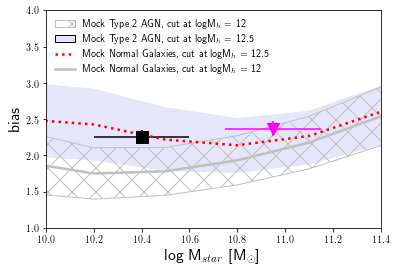

In [439]:
from matplotlib.patches import Rectangle

Mstar, bias, err = np.loadtxt('bvsMstarcut12.txt',skiprows=0,usecols=(0,1,2),unpack=True)


a = plt.plot(Mstarbin,medianbiasstargal,color='red',linewidth=2.5, linestyle=':')
plt.fill_between(Mstarbin,medianbiasstarAGN+errstarAGN,medianbiasstarAGN-errstarAGN,color='lavender')
plt.fill_between(Mstar,bias+err,bias-err,facecolor = 'none',hatch='x',edgecolor='silver')
b = plt.plot(Mstar,bias,color='silver',linewidth=2.5, linestyle='-')

plt.errorbar(10.4, 2.26, yerr=0.09,xerr=0.2,fmt='s',color='black',label='low M$_{star}$',ms=12)
#plt.errorbar(10.4, 2.13, yerr=0.08,xerr=0.25,fmt='s',markerfacecolor = 'white',label='low M$_{star}$, AGN not in groups',ms=12,ecolor='black',markeredgecolor='black')
plt.errorbar(10.95, 2.37, yerr=0.10,xerr=0.2,fmt='v',color='magenta',label='high M$_{star}$',ms=12)
#plt.errorbar(11.2, 2.3, yerr=0.20,xerr=0.15,fmt='v',color='blue',label='logM$_{star}$ $>$ 11',ms=12)
handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),a[0],b[0]]
labels= ["Mock Type 2 AGN, cut at logM$_h$ = 12","Mock Type 2 AGN, cut at logM$_h$ = 12.5", "Mock Normal Galaxies, cut at logM$_h$ = 12.5","Mock Normal Galaxies, cut at logM$_h$ = 12"]

plt.legend(handles, labels,frameon=False,loc='upper left')

#plt.text(14.5, 6.8, r'z = 1.5')
#plt.errorbar(lgMBH, b, yerr=berrup,fmt='o',color='black')
#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{star}$ [M$_{\odot}$]',fontsize='16')
plt.ylabel(r'bias',fontsize='16')
plt.axis([10.,11.4,1.,4.])
plt.savefig("bvsMstar.png")
plt.show()
plt.close()


In [ ]:
nthreads = 4

pi_max = 50

bins = numpy.linspace(0.1, 30, 100)

period = 1000
wp_results = wp(period, pi_max, nthreads, bins, xEQ5low, yEQ5low, zEQ5low,  weights=fEQ5low, weight_type='pair_product',verbose = True)
wrpEQ5AGNlow = wp_results['wp']